In [1]:
import pandas as pd
import numpy as np
import datetime

## Wrangle Data

In [2]:
full_df = pd.read_csv('tracking.csv', parse_dates = ['date', 'last_seen'])
simple_df = full_df.copy()

In [3]:
# In the Python script, I used df.drop_duplicates(), but duplicates containing NaN values were not dropped
# even if they have duplciates.
# I will circumvent this issue by resetting NaN to a different "none"

cols = simple_df.columns

for col in cols:
    simple_df[col] = ['none' if each is np.nan else each for each in simple_df[col]]

simple_df.sort_values('last_seen', ascending = False, inplace = True)
simple_df.drop_duplicates(subset = simple_df.columns[-1], keep = 'first', inplace = True)

In [4]:
# drop all columns unnecessary for analysis
simple_df = simple_df.drop('url', axis = 1)

# only the number of images posted are in our interest
simple_df['images'] = simple_df['images'].apply(lambda x: 0 if (isinstance(x, float) and math.isnan(x)) else len(x.split(',')))

# only the number of characters of a listing's name is important for this analysis
simple_df['name'] = simple_df['name'].apply(lambda x: len(x))

simple_df.head()

,id,name,price,date,location,images,last_seen
19373,7163883410,63,595.0,2020-07-22 08:36:00,We buy used office cubicles and furniture,5,2020-08-21 23:00:10
19183,7166291325,69,0.0,2020-07-26 10:26:00,none,1,2020-08-21 23:00:07
19062,7179307531,18,15.0,2020-08-19 15:53:00,kerny mesa,2,2020-08-21 23:00:05
18935,7179916663,17,10.0,2020-08-18 14:29:00,"Temecula, CA",4,2020-08-21 23:00:03
18856,7176312281,54,1.0,2020-08-12 15:00:00,none,24,2020-08-21 22:00:15


## Find Out For How Long Listings Are Usually Posted

In [16]:
# Let's see for how long each listing was posted

# First, keep only the listings that are not available anymore

latest_seen = simple_df['last_seen'].max()

taken_down_df = simple_df[simple_df['last_seen'] < latest_seen]

# Then, keep only the latest post of each id
latest_taken_down_df = taken_down_df.sort_values('last_seen', ascending = False).groupby('id').first()

latest_taken_down_df.loc[:, 'duration'] = latest_taken_down_df.loc[:, 'last_seen'] - latest_taken_down_df.loc[:, 'date']

avg_duration = np.mean(latest_taken_down_df['duration'])
avg_duration = datetime.timedelta(days = avg_duration.days, seconds = int(avg_duration.seconds)) 

med_duration = np.median(latest_taken_down_df['duration']) / 10 ** 9
med_duration = datetime.timedelta(seconds = int(med_duration))

print('Average time a listing is posted: ', avg_duration)
print('Median time a listing is posted: ', med_duration)

Average time a listing is posted:  11 days, 23:44:08
Median time a listing is posted:  7 days, 8:12:05


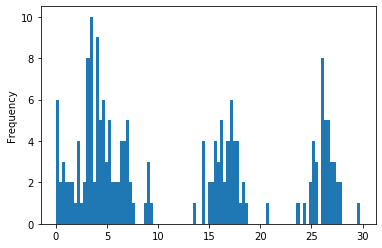

In [24]:
duration_hours = latest_taken_down_df['duration'].apply(lambda x: x.days + x.seconds / 3600 / 24)
duration_hours.plot.hist(bins = 100)   # histogram showing how many days listings stayed on the webstie

In [7]:
# find id of listings that posted twice or more

repost_id = list(simple_df.id)
repost_id = [each for each in repost_id if repost_id.count(each) > 1]
repost_id = list(set(repost_id))

reposts = simple_df[simple_df['id'].isin(repost_id)].sort_values('id')
reposts.groupby('id').count().sort_values('name', ascending = False)

,name,price,date,location,images,last_seen
id,,,,,,
7169545659,9,9,9,9,9,9
7175689700,9,9,9,9,9,9
7178706425,8,0,8,8,8,8
7176312281,8,8,8,8,8,8
7177665853,6,6,6,6,6,6
...,...,...,...,...,...,...
7171684852,2,2,2,2,2,2
7173141601,2,2,2,2,2,2
7174455582,2,2,2,2,2,2
